In [1]:
# OLD ALL NO minmax
# Ver2
# Add descriptive analysis
# Change to balanced accuracy
# GA for selection

import seaborn as sns
import pygad as pygad

import os
import numpy as np
import pandas as pd
from functools import reduce
from dokato_dfa import dfa # local file for dfa
import antropy as ant # for higuchi
import matplotlib.pyplot as plt
from scipy.stats import iqr

## Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [2]:
## Read in the data
# desc
desc = pd.read_csv('../rawdata/gait-in-neurodegenerative-disease-database-1.0.0/subject-description.txt',sep='\t')
desc.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)

# There are missing values in gait speed!
# Impute it with mean value
# I know there is better way to use pipeline but meh, just one column
desc.loc[desc['GaitSpeed(m/sec)'] == "MISSING", 'GaitSpeed(m/sec)'] = np.nan
desc['GaitSpeed(m/sec)'] = pd.to_numeric(desc['GaitSpeed(m/sec)'])
desc.loc[np.isnan(desc['GaitSpeed(m/sec)']), 'GaitSpeed(m/sec)']= np.mean(desc['GaitSpeed(m/sec)'])
desc.head()


# ts data
ts_files_orig = os.listdir('../rawdata/gait-in-neurodegenerative-disease-database-1.0.0/')
ts_files = filter(lambda x: ('ts' in x) & ('example' not in x), ts_files_orig)
# Accumulate ts data in ts_data
ts_data = list()
for file in ts_files:
    tmpdata = pd.read_csv('../rawdata/gait-in-neurodegenerative-disease-database-1.0.0/' + file, sep='\t', header=None)
    tmpdata.columns = ['Elapsed Time (sec)', 'Left Stride Interval (sec)','Right Stride Interval (sec)',
                   'Left Swing Interval (sec)','Right Swing Interval (sec)','Left Swing Interval (% of stride)',
                   'Right Swing Interval (% of stride)','Left Stance Interval (sec)','Right Stance Interval (sec)',
                   'Left Stance Interval (% of stride)','Right Stance Interval (% of stride)',
                   'Double Support Interval (sec)','Double Support Interval (% of stride)']

    # Keeping stride, swing, stance, and DS
    del_cols = tmpdata.columns[[0,5,6,9,10,12]]
    #del_cols = tmpdata.columns[[0]]
    tmpdata = tmpdata.drop(columns=del_cols,axis=1)
    tmpdata['ID'] = file.split('.')[0]
    ts_data.append(tmpdata)
ts_data = reduce(lambda x, y: pd.concat([x,y], ignore_index=True), ts_data)
    
# Merge and voila
all_data = pd.merge(desc, ts_data, on='ID')
all_data.reset_index()
all_data

,ID,GROUP,AGE(YRS),HEIGHT(meters),Weight(kg),gender,GaitSpeed(m/sec),Duration/Severity,Left Stride Interval (sec),Right Stride Interval (sec),Left Swing Interval (sec),Right Swing Interval (sec),Left Stance Interval (sec),Right Stance Interval (sec),Double Support Interval (sec)
0,control1,control,57,1.94,95,f,1.330,0.0,1.0667,1.0600,0.3633,0.3833,0.7033,0.6767,0.3200
1,control1,control,57,1.94,95,f,1.330,0.0,1.0867,1.0733,0.3833,0.3967,0.7033,0.6767,0.3067
2,control1,control,57,1.94,95,f,1.330,0.0,1.0467,1.0733,0.3633,0.3900,0.6833,0.6833,0.2933
3,control1,control,57,1.94,95,f,1.330,0.0,1.0500,1.0400,0.3733,0.3533,0.6767,0.6867,0.3233
4,control1,control,57,1.94,95,f,1.330,0.0,1.0167,1.0400,0.3567,0.3833,0.6600,0.6567,0.2767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15155,als13,subjects,66,1.83,MISSING,m,0.832,34.0,1.4967,1.7133,0.4200,0.5100,1.0767,1.2033,0.5667
15156,als13,subjects,66,1.83,MISSING,m,0.832,34.0,1.5600,1.4733,0.5033,0.5200,1.0567,0.9533,0.5367
15157,als13,subjects,66,1.83,MISSING,m,0.832,34.0,1.5433,1.5633,0.4900,0.5133,1.0533,1.0500,0.5400
15158,als13,subjects,66,1.83,MISSING,m,0.832,34.0,1.5467,1.5500,0.4800,0.5000,1.0667,1.0500,0.5667


Weight missing value: 1


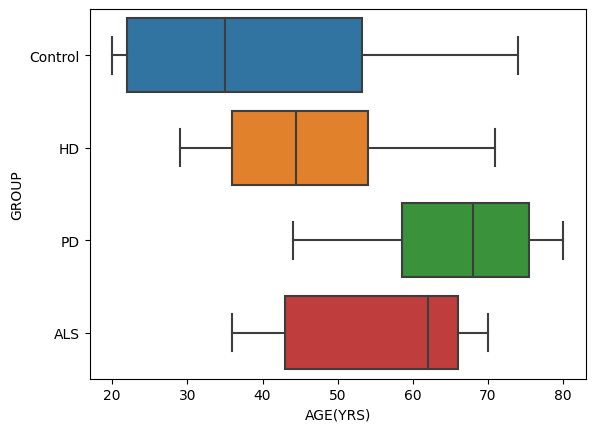

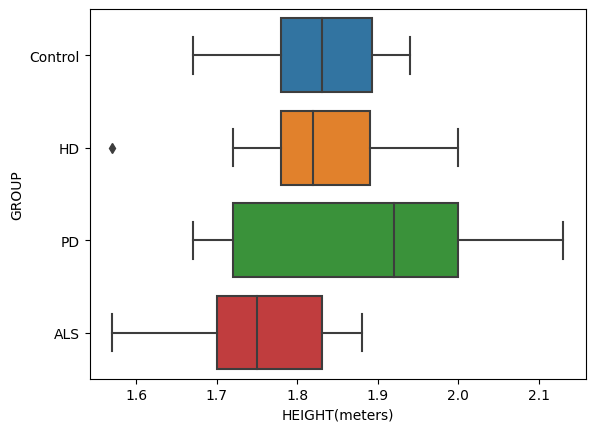

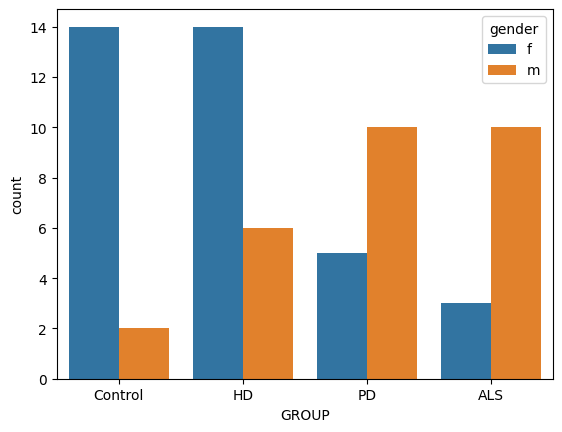

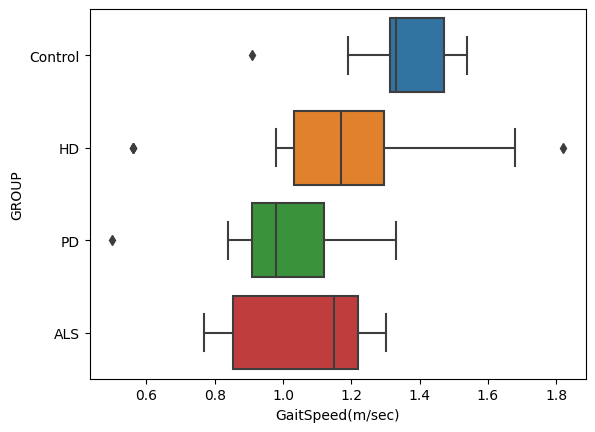

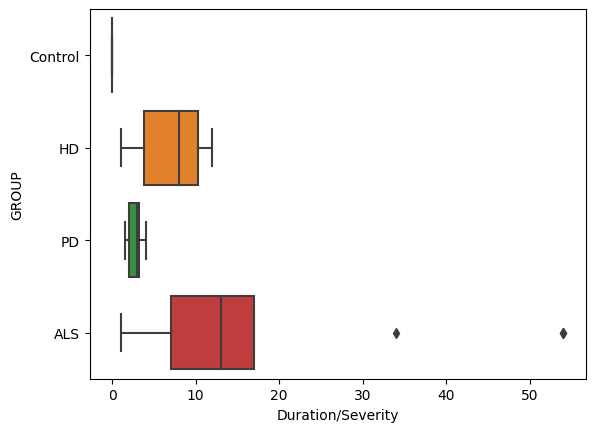

<AxesSubplot: xlabel='Weight(kg)', ylabel='GROUP'>

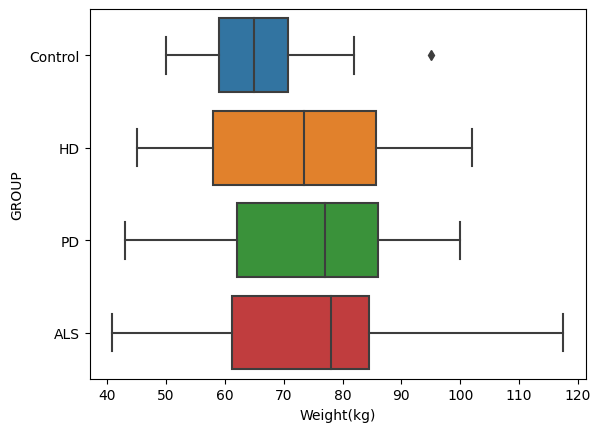

In [3]:
# Descriptive data of patients
# Clean up
desc.loc[desc['GROUP'] == 'subjects','GROUP'] = 'ALS'
desc.loc[desc['GROUP'] == 'park','GROUP'] = 'PD'
desc.loc[desc['GROUP'] == 'hunt','GROUP'] = 'HD'
desc.loc[desc['GROUP'] == 'control','GROUP'] = 'Control'
print('Weight missing value: ' + str(np.sum(desc['Weight(kg)'] == 'MISSING')))
desc.loc[desc['Weight(kg)'] == 'MISSING','Weight(kg)'] = np.nan

sns.boxplot(data=desc,y='GROUP',x='AGE(YRS)')
plt.show()
sns.boxplot(data=desc,x='HEIGHT(meters)',y='GROUP')
plt.show()
sns.countplot(data=desc,hue='gender',x='GROUP')
plt.show()
sns.boxplot(data=desc,x='GaitSpeed(m/sec)',y='GROUP')
plt.show()
sns.boxplot(data=desc,x='Duration/Severity',y='GROUP')
plt.show()

# Weight has missing value, treat it differently
desc2 = desc.loc[:,['GROUP','Weight(kg)']]
desc2 = desc2.dropna()
desc2['Weight(kg)'] = pd.to_numeric(desc2['Weight(kg)'])
sns.boxplot(data=desc2,x='Weight(kg)',y='GROUP')



/Users/note/armbrew/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


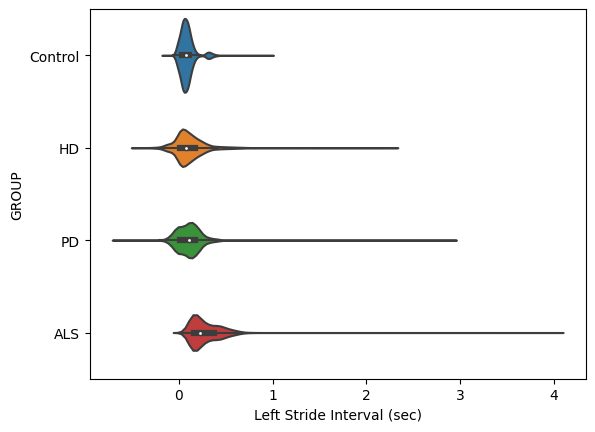

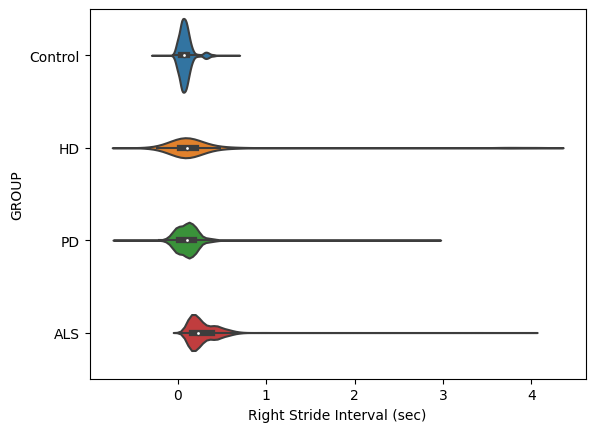

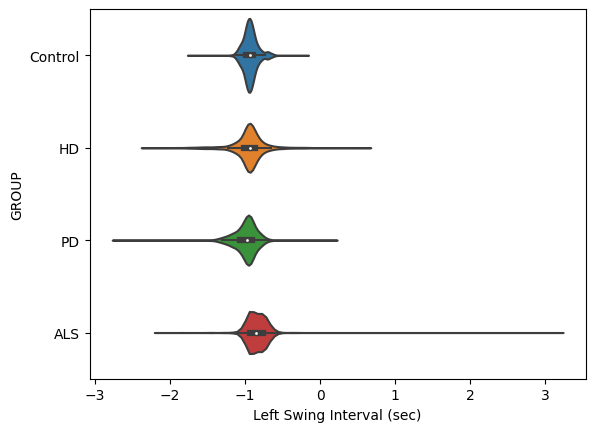

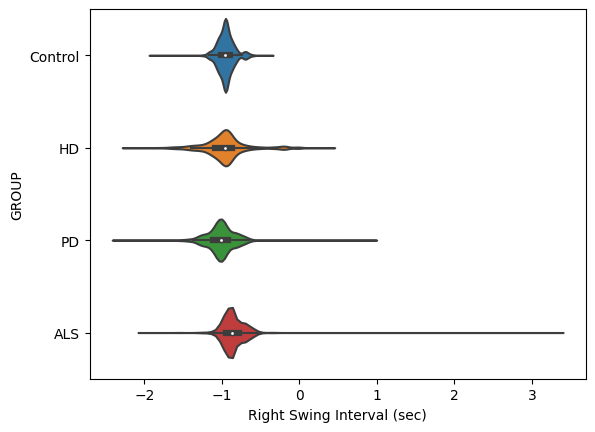

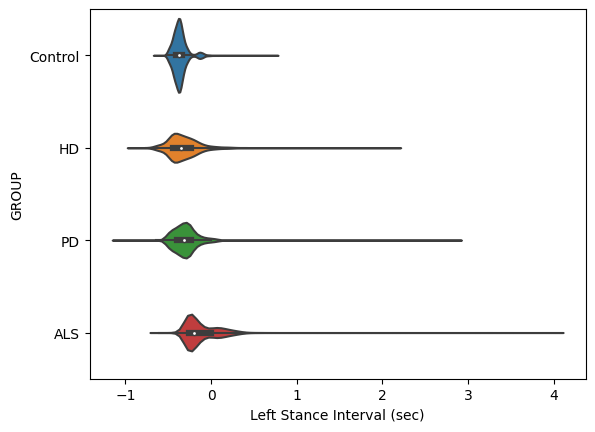

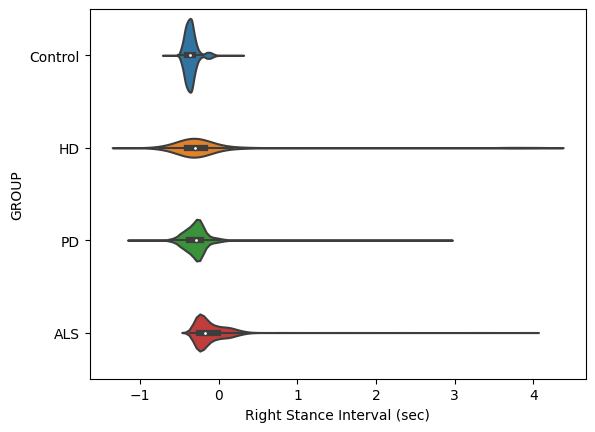

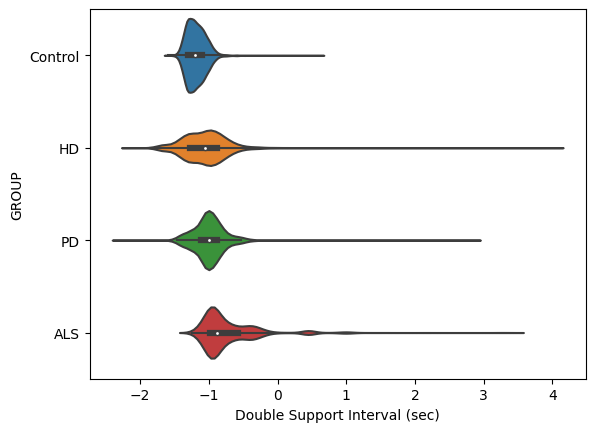

In [4]:
# Gait plot

all_data.loc[all_data['GROUP'] == 'subjects','GROUP'] = 'ALS'
all_data.loc[all_data['GROUP'] == 'park','GROUP'] = 'PD'
all_data.loc[all_data['GROUP'] == 'hunt','GROUP'] = 'HD'
all_data.loc[all_data['GROUP'] == 'control','GROUP'] = 'Control'

all_data2 = all_data.copy()
all_data2.loc[:,tmpdata.columns[0:-1]] = all_data2.loc[:,tmpdata.columns[0:-1]].apply(lambda x: np.log(x))



sns.violinplot(data=all_data2,y='GROUP',x='Left Stride Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Right Stride Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Left Swing Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Right Swing Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Left Stance Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Right Stance Interval (sec)')
plt.show()
sns.violinplot(data=all_data2,y='GROUP',x='Double Support Interval (sec)')
plt.show()


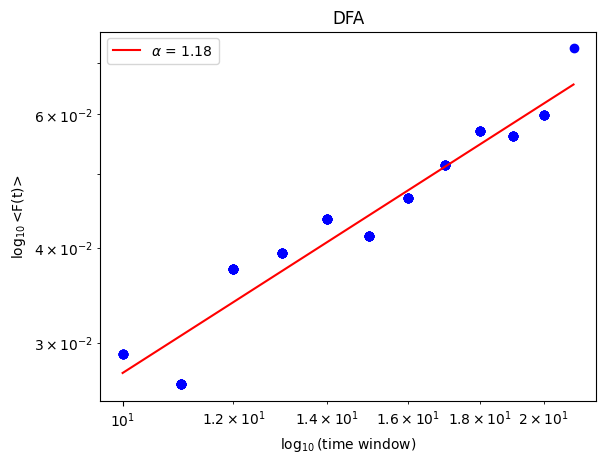

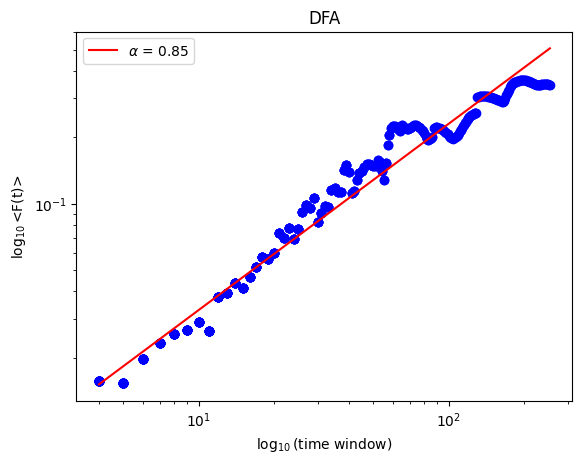

In [5]:
# Showing one result of two different dfa settings

# Gait paper: 10-20
_,_,_ = dfa(all_data.loc[all_data['ID']=='control1','Left Stride Interval (sec)'], scale_lim=[3.4, 4.4], scale_dens=0.01, show=True)
# Proper DFA: 4 points - all points (2^2-2^8 for this case) 
_,_,_ = dfa(all_data.loc[all_data['ID']=='control1','Left Stride Interval (sec)'], scale_lim=[2, 8], scale_dens=0.01, show=True)

In [6]:
## Pre-processing into features
# Helper func for dfa
def dfa_orig(x):
    _,_,val = dfa(x, scale_lim=[2, np.floor(np.log2(len(x)))], scale_dens=0.01)
    return val

def dfa_gait(x):
    _,_,val = dfa(x, scale_lim=[3.4, 4.4], scale_dens=0.01)
    return val

def meanlog(x):
    return np.mean(np.log(x))

def stdlog(x):
    return np.std(np.log(x))

def minlog(x):
    return np.min(np.log(x))

def maxlog(x):
    return np.max(np.log(x))

# Start!
#feats = [dfa_orig, ant.higuchi_fd]
feats = ['std','mean', dfa_orig, ant.higuchi_fd]
#feats = ['std','mean', dfa_orig, dfa_gait, ant.higuchi_fd]
#feats = [stdlog, meanlog, minlog, maxlog, dfa_orig, ant.higuchi_fd]


#feats = ['std','mean', 'min', 'max']

#feats = ['std', dfa_orig, ant.higuchi_fd]
#feats = ['std', ant.higuchi_fd]
#feats = ['std', dfa_orig]


#feats = ['std','mean', dfa_orig, ant.higuchi_fd]



parsed_features = all_data.groupby('ID').agg({
    'Left Stride Interval (sec)': feats,
    'Right Stride Interval (sec)': feats,
    'Left Swing Interval (sec)': feats,
    'Right Swing Interval (sec)': feats,
    'Left Stance Interval (sec)': feats,
    'Right Stance Interval (sec)': feats,
    'Double Support Interval (sec)': feats,
    'GaitSpeed(m/sec)': ['mean'],
})
parsed_features['ID'] = parsed_features.index


# Prepare labels
parsed_features['binary'] = parsed_features['ID'].apply(lambda x: 0 if 'control' in x else 1)
def tmp(x):
    if 'als' in x:
        return 'als'
    elif 'control' in x:
        return 'control'
    elif 'hunt' in x:
        return 'hunt'
    else:
        return 'park'
    
parsed_features['multi'] = parsed_features['ID'].apply(tmp)
parsed_features.drop(columns=['ID'], inplace=True)
parsed_features.reset_index(drop=True, inplace=True)
parsed_features.head()

Left Stride Interval (sec)                                 \
                         std      mean  dfa_orig higuchi_fd   
0                   0.334210  1.298559  0.669102   1.905800   
1                   0.034332  1.133741  0.814093   1.911690   
2                   0.061976  1.215034  0.726433   1.887453   
3                   5.815653  2.281637  0.279847   2.158307   
4                   0.092713  1.520109  0.964115   1.876757   

  Right Stride Interval (sec)                                 \
                          std      mean  dfa_orig higuchi_fd   
0                    0.336559  1.298537  0.657807   1.867804   
1                    0.032930  1.133673  0.839417   1.892354   
2                    0.056668  1.215050  0.757952   1.883018   
3                    5.947309  2.327648  0.335265   2.191532   
4                    0.095548  1.520201  0.919986   1.918380   

  Left Swing Interval (sec)                                 \
                        std      mean  dfa_orig higuchi_fd   
0                  0.050338  0.425860  0.742544   1.999739   
1                  0.013425  0.368307  0.566913   1.987035   
2                  0.024103  0.396900  0.342136   1.976062   
3                  2.122176  0.666611 -0.509935   2.271002   
4                  0.046893  0.477576  0.332352   2.037554   

  Right Swing Interval (sec)                                 \
                         std      mean  dfa_orig higuchi_fd   
0                   0.038291  0.391337  0.675700   1.960895   
1                   0.018730  0.369240  0.588953   1.977122   
2                   0.018578  0.411180  0.474235   1.988181   
3                   2.505307  0.676504 -0.723407   2.309671   
4                   0.048578  0.496978  0.663901   1.971224   

  Left Stance Interval (sec)                                 \
                         std      mean  dfa_orig higuchi_fd   
0                   0.332522  0.872697  0.645131   1.904874   
1                   0.031849  0.765432  0.801799   1.920492   
2                   0.051305  0.818136  0.795773   1.848033   
3                   5.389055  1.615032  0.210120   2.174432   
4                   0.092297  1.042534  0.982119   1.790659   

  Right Stance Interval (sec)                                 \
                          std      mean  dfa_orig higuchi_fd   
0                    0.316666  0.907201  0.652688   1.874188   
1                    0.024035  0.764428  0.840280   1.901472   
2                    0.052680  0.803876  0.799298   1.850320   
3                    5.326724  1.651150  0.403156   2.266294   
4                    0.078638  1.023223  0.905899   1.885179   

  Double Support Interval (sec)                                 \
                            std      mean  dfa_orig higuchi_fd   
0                      0.309871  0.481356  0.639829   1.918113   
1                      0.022624  0.396191  0.805341   1.937682   
2                      0.055895  0.406959  0.743209   1.864637   
3                      3.332034  0.993768  0.408125   2.079290   
4                      0.080106  0.545557  0.902805   1.827702   

  GaitSpeed(m/sec) binary multi  
              mean               
0            1.302      1   als  
1            1.219      1   als  
2            1.283      1   als  
3            0.831      1   als  
4            0.832      1   als

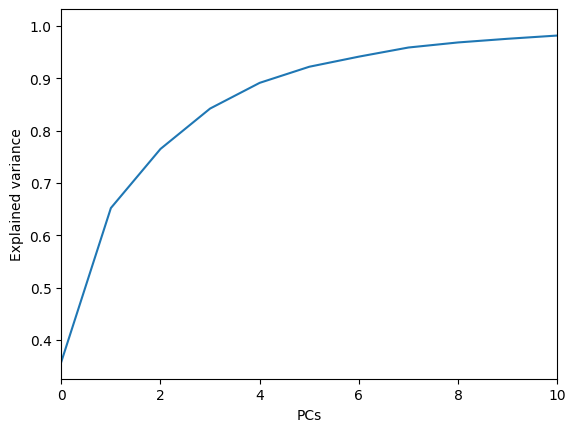

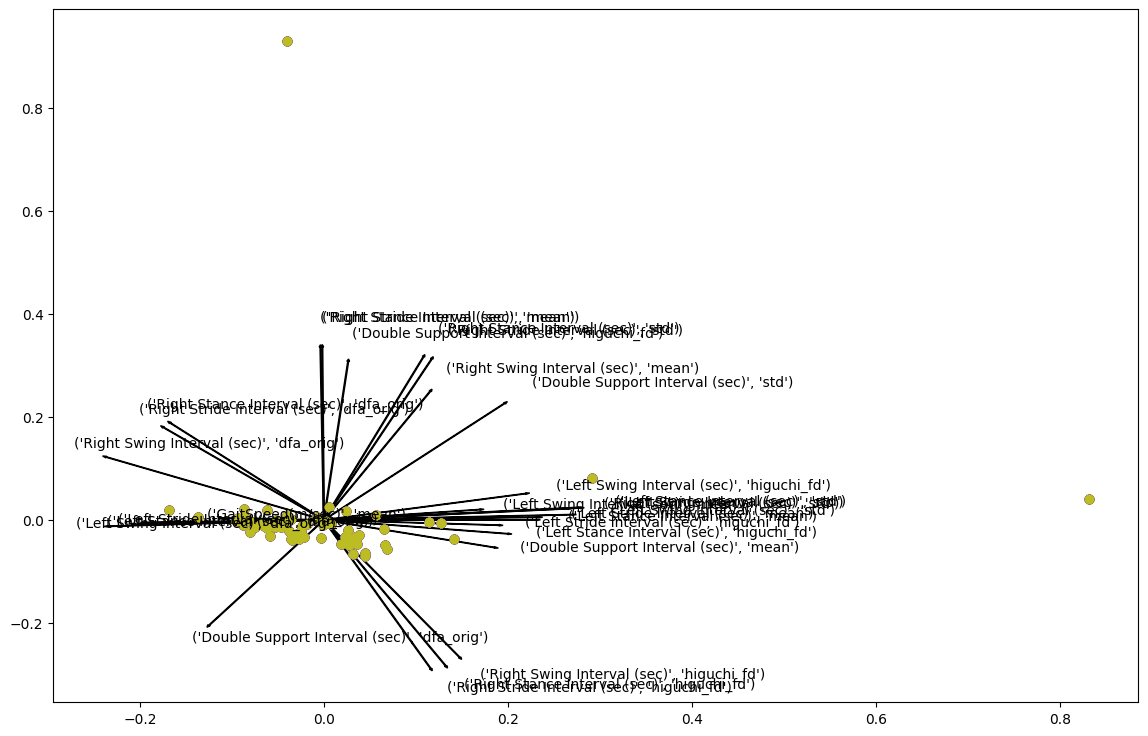

In [7]:
# EDA with PCA, disease vs. non-disease
scaler = StandardScaler()
pca = PCA()
X_pca = pca.fit_transform(scaler.fit_transform(parsed_features.drop(columns=['binary','multi'])))
#X_pca = pca.fit_transform(parsed_features.drop(columns=['binary','multi']))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim([0,10])
plt.xlabel('PCs')
plt.ylabel('Explained variance')
plt.show()



PC1 = X_pca[:,0]
PC2 = X_pca[:,1]
ldngs = pca.components_
scalePC1 = 1/(PC1.max() - PC1.min())
scalePC2 = 1/(PC2.max() - PC2.min())
features = parsed_features.drop(columns=['binary','multi']).columns

fig, ax = plt.subplots(figsize=(14, 9))
 
for i, feature in enumerate(features):
    ax.arrow(0, 0, ldngs[0, i], 
             ldngs[1, i])
    ax.text(ldngs[0, i] * 1.15, 
            ldngs[1, i] * 1.15, 
            feature)
 
    ax.scatter(PC1 * scalePC1, PC2 * scalePC2)

In [8]:
# EDA with correlation
# Binary correlation
EDA1 = parsed_features.drop(columns=['multi']).corr(method='spearman')
EDA1['binary'].sort_values(ascending=False)


binary                                       1.000000
Right Stance Interval (sec)    std           0.607496
Left Swing Interval (sec)      std           0.605543
Right Swing Interval (sec)     std           0.599683
Right Stride Interval (sec)    std           0.591869
Double Support Interval (sec)  std           0.550848
Left Stride Interval (sec)     std           0.544988
Left Stance Interval (sec)     std           0.533268
Double Support Interval (sec)  mean          0.484434
Left Stride Interval (sec)     higuchi_fd    0.445367
Left Stance Interval (sec)     higuchi_fd    0.425833
Right Stance Interval (sec)    mean          0.425833
                               higuchi_fd    0.408253
Left Stance Interval (sec)     mean          0.382859
Right Stride Interval (sec)    mean          0.349652
Left Swing Interval (sec)      higuchi_fd    0.343792
Right Stride Interval (sec)    higuchi_fd    0.318398
Left Stride Interval (sec)     mean          0.314492
Double Support Interval (sec

In [9]:
# Start training, train-test split
train_orig, test_orig = train_test_split(parsed_features, test_size=0.3, random_state=42)
train_x = train_orig.drop(columns=['binary','multi'])
train_y_binary = train_orig['binary']
train_y_multi = train_orig['multi']

test_x = test_orig.drop(columns=['binary','multi'])
test_y_binary = test_orig['binary']
test_y_multi = test_orig['multi']

# ALL
all_x = parsed_features.drop(columns=['binary','multi'])
all_y_binary = parsed_features['binary']
all_y_multi = parsed_features['multi']

In [10]:
test_y_multi

52       park
58       park
0         als
44       hunt
5         als
36       hunt
16    control
12        als
25    control
61       park
56       park
9         als
40       hunt
13    control
34       hunt
50       park
3         als
17    control
49       park
8         als
Name: multi, dtype: object

In [11]:
# SVM, binary, split
SVMChyperparams = {
    "gamma": [0.01, 0.1, 1, 10, 100],
    "C": [0.01, 0.1, 1, 10, 100],
}
SVMC = SVC(kernel='rbf')
SVMC_clf = GridSearchCV(SVMC, SVMChyperparams, verbose = 1, scoring='balanced_accuracy', n_jobs=-1)
SVMC_clf.fit(train_x,train_y_binary)
print(SVMC_clf.best_estimator_)
print(SVMC_clf.best_score_)
print(classification_report(SVMC_clf.predict(test_x),test_y_binary))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(SVMC_clf.predict(test_x), test_y_binary)}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVC(C=100, gamma=1)
0.8333333333333333
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.81      0.93      0.87        14

    accuracy                           0.80        20
   macro avg       0.78      0.71      0.73        20
weighted avg       0.79      0.80      0.79        20

test balanced_accuracy of all is 0.7142857142857143


In [12]:
# SVM, OVO multi, split
SVMCOVOhyperparams = {
    "estimator__gamma": [0.01, 0.1, 1, 10, 100],
    "estimator__C": [1E-5, 1E-4, 0.01, 0.1, 1, 10]
}
SVMCOVO_model = OneVsOneClassifier(SVC(kernel='rbf'))
SVMCOVO_clf = GridSearchCV(SVMCOVO_model, SVMCOVOhyperparams, verbose = 1, scoring='balanced_accuracy', n_jobs=-1)
SVMCOVO_clf.fit(train_x,train_y_multi)
print(SVMCOVO_clf.best_estimator_)
print(SVMCOVO_clf.best_score_)
print(classification_report(SVMCOVO_clf.predict(test_x),test_y_multi))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(SVMCOVO_clf.predict(test_x),test_y_multi)}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
OneVsOneClassifier(estimator=SVC(C=10, gamma=0.1))
0.4708333333333333
              precision    recall  f1-score   support

         als       0.17      1.00      0.29         1
     control       1.00      0.57      0.73         7
        hunt       0.50      0.18      0.27        11
        park       0.00      0.00      0.00         1

    accuracy                           0.35        20
   macro avg       0.42      0.44      0.32        20
weighted avg       0.63      0.35      0.42        20

test balanced_accuracy of all is 0.4383116883116883


In [13]:
# Random forest, binary, split
RFChyperparams = {
    "min_samples_leaf": [3,4,5,6],
}
rfc = RandomForestClassifier(random_state=42)
rfc_clf = GridSearchCV(rfc,RFChyperparams, verbose=1, scoring='balanced_accuracy', n_jobs=-1)
rfc_clf.fit(train_x,train_y_binary)
print(rfc_clf.best_estimator_)
print(rfc_clf.best_score_)
print(classification_report(rfc_clf.predict(test_x),test_y_binary))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(rfc_clf.predict(test_x),test_y_binary)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier(min_samples_leaf=3, random_state=42)
0.819047619047619
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.93      0.90        15

    accuracy                           0.85        20
   macro avg       0.81      0.77      0.78        20
weighted avg       0.84      0.85      0.84        20

test balanced_accuracy of all is 0.7666666666666666


In [14]:
# Random forest, multi, split
RFChyperparams = {
    "min_samples_leaf": [3,4,5,6],
}
rfc = RandomForestClassifier(random_state=42)
rfc_clf = GridSearchCV(rfc,RFChyperparams, verbose=1, scoring='balanced_accuracy', n_jobs=-1)
rfc_clf.fit(train_x,train_y_multi)
print(rfc_clf.best_estimator_)
print(rfc_clf.best_score_)
print(classification_report(rfc_clf.predict(test_x),test_y_multi))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(rfc_clf.predict(test_x),test_y_multi)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier(min_samples_leaf=3, random_state=42)
0.5666666666666667
              precision    recall  f1-score   support

         als       0.67      0.80      0.73         5
     control       0.75      0.60      0.67         5
        hunt       0.50      0.25      0.33         8
        park       0.17      0.50      0.25         2

    accuracy                           0.50        20
   macro avg       0.52      0.54      0.49        20
weighted avg       0.57      0.50      0.51        20

test balanced_accuracy of all is 0.5375


In [15]:
### GA part

SVMChyperparams = {
    "gamma": [0.01, 0.1, 1, 10, 100],
    "C": [0.01, 0.1, 1, 10, 100],
}

def fitness_func(ga,sol,sol_idx):
    sol2 = list(map(lambda x: True if x==1 else False,sol))
    train_x_chosen = train_x.loc[:,sol2]
    SVMC = SVC(kernel='rbf')
    SVMC_clf = GridSearchCV(SVMC, SVMChyperparams, verbose = 0, scoring='balanced_accuracy', n_jobs=-1)
    SVMC_clf.fit(train_x_chosen,train_y_binary)
    return SVMC_clf.best_score_

ga_inst = pygad.GA(
fitness_func = fitness_func,
num_generations = 100,
sol_per_pop = 100,
num_parents_mating = 10,
num_genes = len(train_x.columns),
gene_space = [0,1])

    
ga_inst.run()
ga_inst.best_solution()

/Users/note/armbrew/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]),
 1.0,
 0)

In [16]:
feazo,_,_ = ga_inst.best_solution()
featf = list(map(lambda x: True if x==1 else False,feazo))
train_x_final = train_x.loc[:,featf]
test_x_final = test_x.loc[:,featf]
print(test_x_final.columns)

SVMC = SVC(kernel='rbf')
SVMC_clf = GridSearchCV(SVMC,SVMChyperparams,verbose=1,scoring='balanced_accuracy', n_jobs=-1)
SVMC_clf.fit(train_x_final,train_y_binary)

print(SVMC_clf.best_estimator_)
print(SVMC_clf.best_score_)
print(classification_report(SVMC_clf.predict(test_x_final),test_y_binary))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(SVMC_clf.predict(test_x_final), test_y_binary)}")

MultiIndex([(   'Left Stride Interval (sec)',        'std'),
            (   'Left Stride Interval (sec)',   'dfa_orig'),
            (   'Left Stride Interval (sec)', 'higuchi_fd'),
            (  'Right Stride Interval (sec)',        'std'),
            (  'Right Stride Interval (sec)',   'dfa_orig'),
            (    'Left Swing Interval (sec)', 'higuchi_fd'),
            (   'Left Stance Interval (sec)',        'std'),
            ('Double Support Interval (sec)',        'std'),
            ('Double Support Interval (sec)',   'dfa_orig'),
            ('Double Support Interval (sec)', 'higuchi_fd')],
           )
Fitting 5 folds for each of 25 candidates, totalling 125 fits
SVC(C=10, gamma=10)
1.0
              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.81      0.87      0.84        15

    accuracy                           0.75        20
   macro avg       0.66      0.63      0.64        20
weighted avg      

In [17]:
### GA part 2, limiting tries for SVM

SVMChyperparams = {
    "gamma": [10],
    "C": [0.1,1,10],
}

def fitness_func(ga,sol,sol_idx):
    sol2 = list(map(lambda x: True if x==1 else False,sol))
    train_x_chosen = train_x.loc[:,sol2]
    SVMC = SVC(kernel='rbf')
    SVMC_clf = GridSearchCV(SVMC, SVMChyperparams, verbose = 0, scoring='balanced_accuracy', n_jobs=-1)
    SVMC_clf.fit(train_x_chosen,train_y_binary)
    return SVMC_clf.best_score_

ga_inst2 = pygad.GA(
fitness_func = fitness_func,
num_generations = 100,
sol_per_pop = 100,
num_parents_mating = 10,
num_genes = len(train_x.columns),
gene_space = [0,1])

    
ga_inst2.run()
ga_inst2.best_solution()

/Users/note/armbrew/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.]),
 0.9,
 0)

In [18]:
feazo,_,_ = ga_inst2.best_solution()
featf = list(map(lambda x: True if x==1 else False,feazo))
train_x_final = train_x.loc[:,featf]
test_x_final = test_x.loc[:,featf]
print(test_x_final.columns)
SVMC = SVC(kernel='rbf')
SVMC_clf = GridSearchCV(SVMC,SVMChyperparams,verbose=1,scoring='balanced_accuracy', n_jobs=-1)
SVMC_clf.fit(train_x_final,train_y_binary)

print(SVMC_clf.best_estimator_)
print(SVMC_clf.best_score_)
print(classification_report(SVMC_clf.predict(test_x_final),test_y_binary))
print(f"test balanced_accuracy of all is {balanced_accuracy_score(SVMC_clf.predict(test_x_final), test_y_binary)}")

MultiIndex([(   'Left Stride Interval (sec)',       'mean'),
            (   'Left Stride Interval (sec)',   'dfa_orig'),
            (   'Left Stride Interval (sec)', 'higuchi_fd'),
            (  'Right Stride Interval (sec)',        'std'),
            (  'Right Stride Interval (sec)',   'dfa_orig'),
            (    'Left Swing Interval (sec)',        'std'),
            (    'Left Swing Interval (sec)',       'mean'),
            (    'Left Swing Interval (sec)',   'dfa_orig'),
            (   'Right Swing Interval (sec)',       'mean'),
            (   'Right Swing Interval (sec)',   'dfa_orig'),
            (   'Right Swing Interval (sec)', 'higuchi_fd'),
            (   'Left Stance Interval (sec)',       'mean'),
            (  'Right Stance Interval (sec)',        'std'),
            (  'Right Stance Interval (sec)',       'mean'),
            ('Double Support Interval (sec)',        'std'),
            ('Double Support Interval (sec)', 'higuchi_fd'),
            (           